# Imports

In [17]:
import random
from datetime import datetime
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

# Dataset Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!mkdir /content/dataset

In [5]:
!unzip '/content/drive/MyDrive/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (8).jp

# Hyperparameters Setup

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_EPOCHS = 20

# Model Setup

In [19]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# images generator
train_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 1233,
                                          color_mode = 'rgb',
                                          shuffle = True,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          color_mode = 'rgb',
                                          shuffle = False,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         seed = 1,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


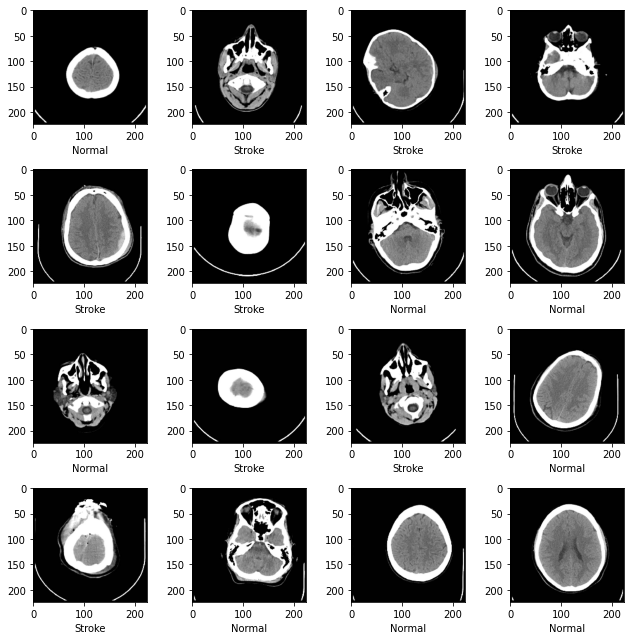

In [20]:
images, labels = next(train_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.set_xlabel(list(train_set.class_indices)[label.astype(int)])
plt.tight_layout()
plt.show()

# Build Model

In [21]:
# create VGG16 base model
base_model = VGG16(input_shape = INPUT_SHAPE, 
                   include_top=False, 
                   weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# add dense layers to CNN
classifier = Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(units = 512, activation="relu"))
classifier.add(Dropout(0.3))
classifier.add(Dense(units = 1, activation="sigmoid", name = 'Output'))

# compile classifier
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train Model

In [24]:
# train the model
start = datetime.now()
print(datetime.now())

history = classifier.fit(train_set, 
                         steps_per_epoch = STEP_SIZE_TRAIN,
                         epochs = NUM_EPOCHS, 
                         validation_data = valid_set,
                         validation_steps = STEP_SIZE_VALID)

end = datetime.now()
print(end-start)

2021-11-20 13:36:08.239447
Epoch 1/20
56/56 [==============================] - 8s 131ms/step - loss: 1.7630 - accuracy: 0.6122 - val_loss: 0.7653 - val_accuracy: 0.6451
Epoch 2/20
56/56 [==============================] - 7s 126ms/step - loss: 0.3696 - accuracy: 0.8383 - val_loss: 0.6644 - val_accuracy: 0.6562
Epoch 3/20
56/56 [==============================] - 7s 127ms/step - loss: 0.2625 - accuracy: 0.8926 - val_loss: 0.6497 - val_accuracy: 0.6920
Epoch 4/20
56/56 [==============================] - 7s 126ms/step - loss: 0.1784 - accuracy: 0.9412 - val_loss: 0.9458 - val_accuracy: 0.6518
Epoch 5/20
56/56 [==============================] - 8s 147ms/step - loss: 0.1254 - accuracy: 0.9661 - val_loss: 0.6831 - val_accuracy: 0.7344
Epoch 6/20
56/56 [==============================] - 7s 126ms/step - loss: 0.0907 - accuracy: 0.9836 - val_loss: 0.8261 - val_accuracy: 0.6853
Epoch 7/20
56/56 [==============================] - 8s 145ms/step - loss: 0.0710 - accuracy: 0.9859 - val_loss: 0.8932 - 

# Evaluate Model

In [25]:
# evaluate accuracy and loss
(eval_loss, eval_accuracy) = classifier.evaluate(valid_set, batch_size = BATCH_SIZE, verbose = 1)
print("accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("loss: {}".format(eval_loss)) 

15/15 [==============================] - 2s 117ms/step - loss: 1.4097 - accuracy: 0.6844
accuracy: 68.44%
loss: 1.4097439050674438


In [26]:
# check class indices and labels
valid_set.class_indices

{'Normal': 0, 'Stroke': 1}

# Predict

Confusion Matrix
[[121   4]
 [ 73  52]]

Classification Report
              precision    recall  f1-score   support

      Normal       0.62      0.97      0.76       125
      Stroke       0.93      0.42      0.57       125

    accuracy                           0.69       250
   macro avg       0.78      0.69      0.67       250
weighted avg       0.78      0.69      0.67       250



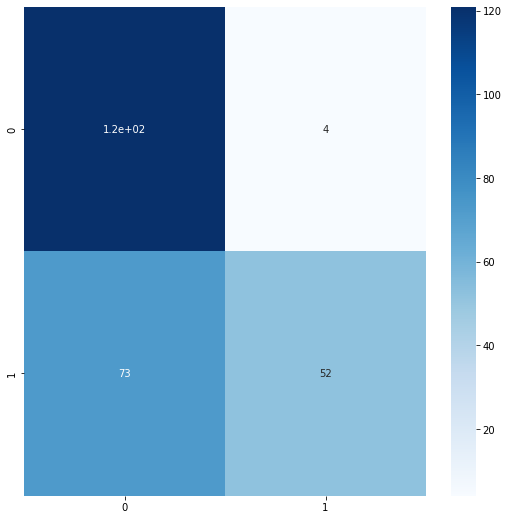

In [27]:
# confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = classifier.predict(test_set)
y_pred = (y_pred > 0.8).astype("int32")
confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)